In [ ]:
import cv2
import numpy as np
import seaborn as sns
from os import listdir
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img,img_to_array
from keras.utils import img_to_array
# from keras_preprocessing.image import img_to_array
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,InputLayer,Flatten, Dropout, Dense,Activation

In [ ]:
!pip install split-folders #for spliting dataset with a given ratio
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
IMAGE_SIZE = 256
BATCH_SIZE =8
EPOCHS = 50
CHANNELS=3
LR = 1e-4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
splitfolders.ratio('/content/drive/MyDrive/', output="/content/drive/MyDrive/", seed=1335, ratio=(0.7, 0.1,0.2))

Copying files: 54 files [00:02, 19.59 files/s]


In [ ]:
Image_Generator = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.3,
    fill_mode="reflect"
)

In [ ]:
train='/content/drive/MyDrive/New/train'
val='/content/drive/MyDrive/New/val'
test='/content/drive/MyDrive/New/test'

In [ ]:
train_generator=Image_Generator.flow_from_directory(
    train,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    color_mode="rgb",
    shuffle=True,
    seed=123
)


Found 5766 images belonging to 5 classes.


In [ ]:
val_datagen=ImageDataGenerator(
    rescale=1.0/255,
)
val_generator=val_datagen.flow_from_directory(
    val,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="sparse",
    shuffle=True,
    seed=123
)


Found 470 images belonging to 5 classes.


In [ ]:
test_datagen=ImageDataGenerator(
    rescale=1.0/255,
)
test_generator=test_datagen.flow_from_directory(
    test,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    color_mode="rgb",
    class_mode="sparse",
)

Found 686 images belonging to 5 classes.


In [ ]:
#number of train,val and test dataset
train_generator.samples,val_generator.samples,test_generator.samples

(5766, 470, 686)

In [ ]:
class_name_indices=train_generator.class_indices
class_names=list(class_name_indices.keys())
class_names

['non1', 'test', 'train', 'val', 'vi']

In [ ]:
num_classes = len(class_names)
num_classes

5

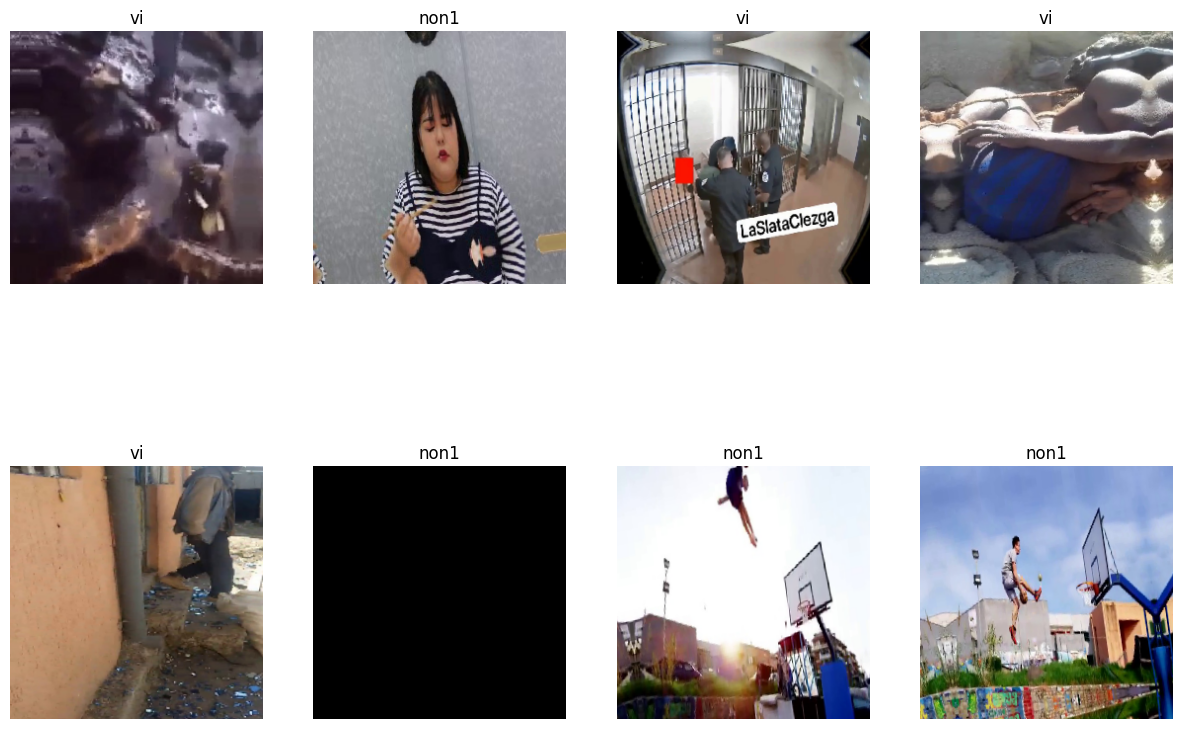

In [ ]:
plt.figure(figsize=(15,16))
for image_batch,label_batch in train_generator:
    for i in range(8):
        plt.subplot(3,4,i+1)
        plt.imshow((image_batch[i]*255).astype(np.uint8))
        plt.title( class_names[int(label_batch[i])])
        plt.axis('off')
    break

In [ ]:
input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model =Sequential([
        InputLayer(input_shape=input_shape),


       Conv2D(32, (3,3),padding='same', activation='relu'),
         MaxPooling2D((2, 2)),

          Conv2D(64, (3,3),padding='same', activation='relu'),
         MaxPooling2D((2, 2)),

         Conv2D(128, (3,3),padding='same', activation='relu'),
         MaxPooling2D((2, 2)),

         Conv2D(256, (3,3), padding='same',activation='relu'),
         MaxPooling2D((2, 2)),

         Conv2D(512, (3, 3),padding='same',activation='relu'),
         MaxPooling2D((2, 2)),

         Conv2D(1024, (3, 3),padding='same',activation='relu'),
         MaxPooling2D((2, 2)),
         Dropout(0.5),

         Conv2D(1024, (3, 3),padding='same',activation='relu'),
         MaxPooling2D((2, 2)),
         Dropout(0.5),

         Flatten(),

         Dense(1024,activation='relu'),
         Dense(128,activation='relu'),

         Dense(64,activation='relu'),

         Dense(4,activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

In [ ]:
model_check_point=ModelCheckpoint(filepath="/content/drive/MyDrive/New/best_model2.h5",
                   monitor="val_loss",
                   verbose=0,
                   save_best_only=True)
early_stop=EarlyStopping(monitor="val_accuracy",patience=30,verbose=1)
log_csv=CSVLogger('/content/drive/MyDrive/New/my_logs2.csv',separator=',',append=False)
call_backs=[model_check_point,early_stop,log_csv]
opt = Adam(learning_rate=LR)

In [ ]:
model.compile(
optimizer=opt,
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])
print("[INFO] training network...")

[INFO] training network...


In [ ]:
steps_per_epoch=int((train_generator.samples)/BATCH_SIZE)
validation_step=int((val_generator.samples)/BATCH_SIZE)
steps_per_epoch,validation_step

(720, 58)

In [ ]:
history=model.fit(
     train_generator,
     verbose=1,
     epochs=30,
     callbacks=call_backs,
     batch_size=BATCH_SIZE,
     validation_data=val_generator,
     steps_per_epoch=steps_per_epoch,
     validation_steps=validation_step

)

Epoch 1/30
720/720 [==============================] - 686s 937ms/step - loss: nan - accuracy: 0.5625 - val_loss: nan - val_accuracy: 0.5022
Epoch 2/30
720/720 [==============================] - 159s 221ms/step - loss: nan - accuracy: 0.5643 - val_loss: nan - val_accuracy: 0.5022
Epoch 3/30
720/720 [==============================] - 159s 220ms/step - loss: nan - accuracy: 0.5636 - val_loss: nan - val_accuracy: 0.4978
Epoch 4/30
720/720 [==============================] - 156s 217ms/step - loss: nan - accuracy: 0.5636 - val_loss: nan - val_accuracy: 0.4978
Epoch 5/30
720/720 [==============================] - 158s 219ms/step - loss: nan - accuracy: 0.5637 - val_loss: nan - val_accuracy: 0.5022
Epoch 6/30
720/720 [==============================] - 163s 226ms/step - loss: nan - accuracy: 0.5637 - val_loss: nan - val_accuracy: 0.5043
Epoch 7/30
720/720 [==============================] - 158s 220ms/step - loss: nan - accuracy: 0.5636 - val_loss: nan - val_accuracy: 0.5043
Epoch 8/30
720/720 [

In [ ]:
model.evaluate(test_generator)

86/86 [==============================] - 128s 2s/step - loss: nan - accuracy: 0.5612


[nan, 0.5612244606018066]

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

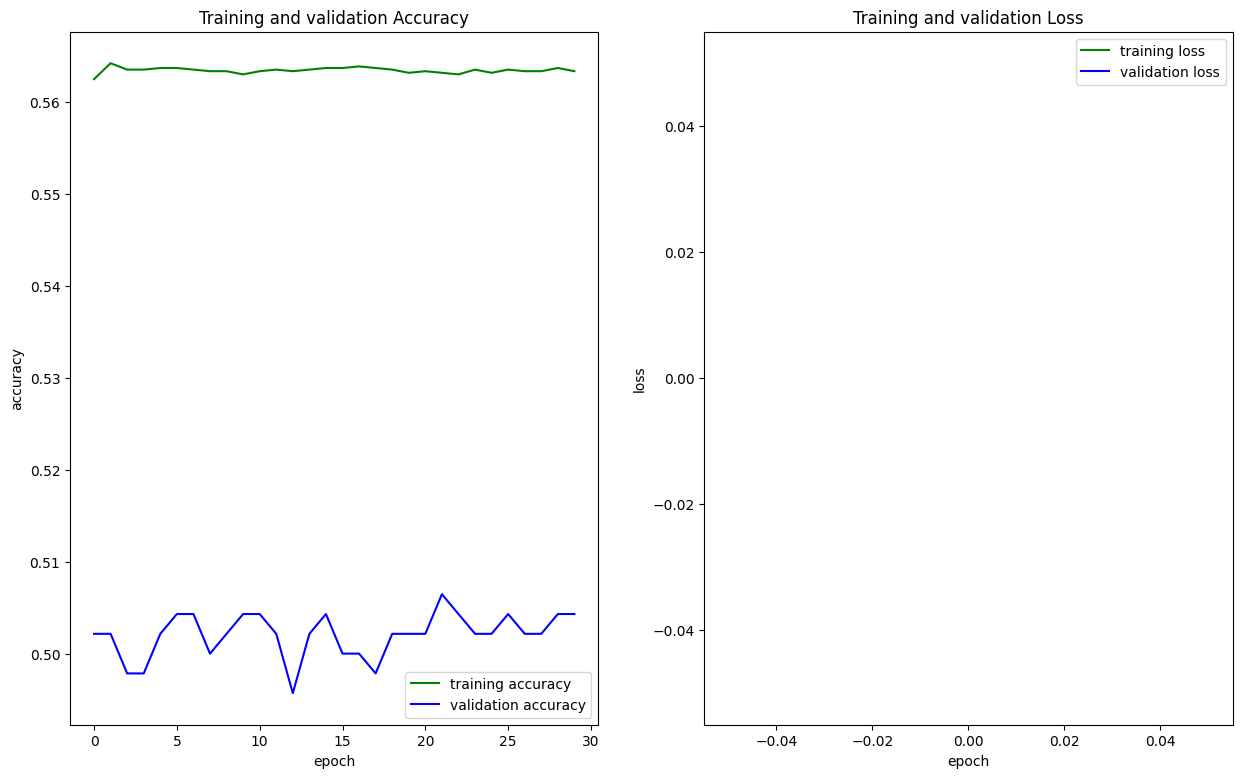

In [ ]:
plt.figure(figsize=(15,9))
#accuracy graph
plt.subplot(1,2,1)
plt.plot(acc,'g',label='training accuracy')
plt.plot(val_acc,'b',label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Training and validation Accuracy')

#loss graph
plt.subplot(1,2,2)
plt.plot(loss,'g',label='training loss')
plt.plot(val_loss,'b',label='validation loss')
plt.legend(loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Training and validation Loss')
plt.show()

In [ ]:
pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


86/86 [==============================] - 9s 102ms/step


<Axes: >

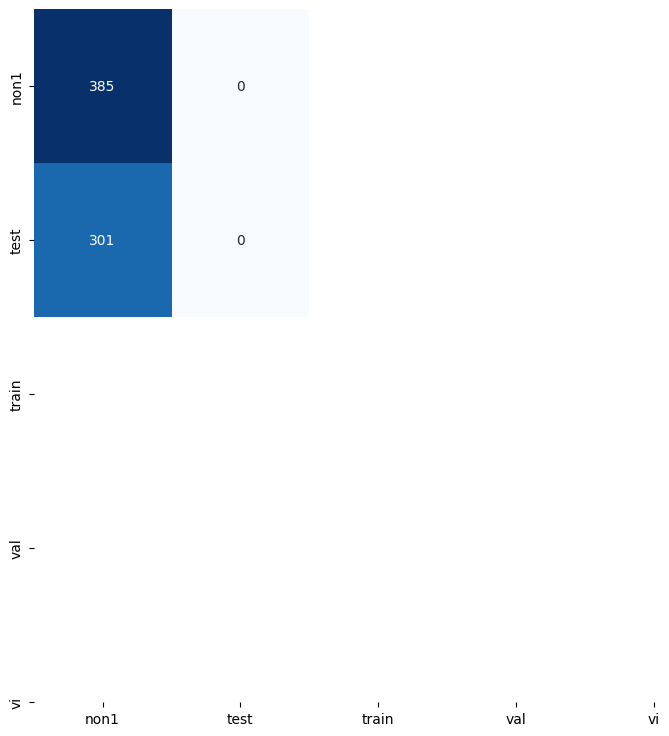

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(test_generator)
plt.figure(figsize=(8,9))
y_prediction_labels=[np.argmax(label) for label in y_pred]
cm=confusion_matrix(test_generator.classes,y_prediction_labels)
sns.heatmap(cm,annot=True,cmap="Blues",cbar=False,fmt='d',xticklabels=class_names,yticklabels=class_names,)

In [ ]:
Y_pred = model.predict(test_generator, test_generator.samples // BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')

print(classification_report(test_generator.classes, y_pred))

86/86 [==============================] - 8s 96ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       385
           4       0.00      0.00      0.00       301

    accuracy                           0.56       686
   macro avg       0.28      0.50      0.36       686
weighted avg       0.31      0.56      0.40       686



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i])
    img_array=tf.expand_dims(img_array,0)#create a batch
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 22ms/step


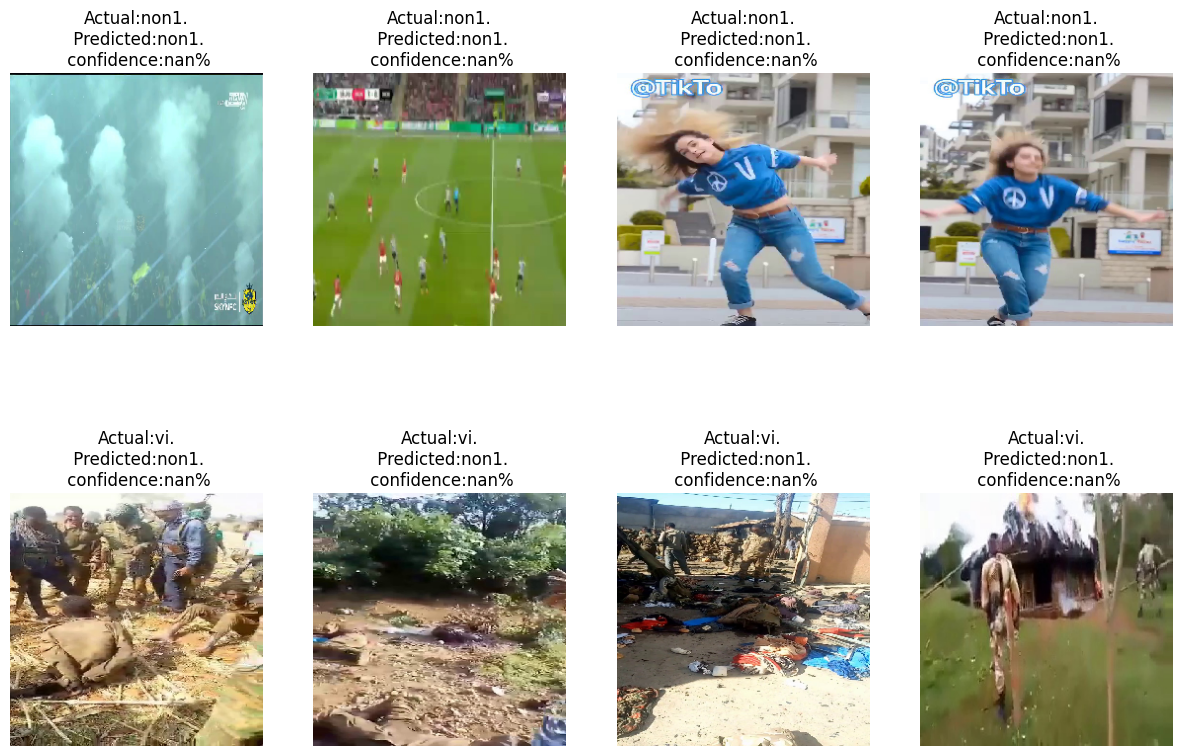

In [ ]:
plt.figure(figsize=(15,10))
for images,labels in test_generator:
    for i in range (8):
        plt.subplot(2,4,i+1)
        plt.imshow(images[i])

        predicted_class,confidence=predict(model,images[i])
        actual_class=class_names[int(labels[i])]

        plt.title(f"Actual:{actual_class}.\n Predicted:{predicted_class}.\n confidence:{confidence}%")
        plt.axis('off')
    plt.show()
    break

In [ ]:
model.save('/content/drive/MyDrive/New/myModel3.h5')

In [ ]:
my_model=load_model('myModel2.h5')

In [ ]:
train_loss,train_acc=my_model.evaluate(train_generator,steps=steps_per_epoch,verbose=0)
val_loss,val_acc=my_model.evaluate(val_generator,steps=validation_step ,verbose=0)
print('Train: %0.3f,Test: %0.3f' %(train_acc,val_acc))
print('Train_Loss: %0.3f,Test_Loss: %0.3f' %(train_loss,val_loss))

Train: 0.564,Test: 0.500
Train_Loss: nan,Test_Loss: nan


In [ ]:
my_model.evaluate(test_generator)

86/86 [==============================] - 8s 95ms/step - loss: nan - accuracy: 0.5612


[nan, 0.5612244606018066]

In [ ]:
pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model.state_dict(), path)

NameError: ignored